In [17]:
from dotenv import dotenv_values
from langchain_core.messages import HumanMessage
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from PIL import Image
import matplotlib.pyplot as plt
import base64


In [3]:
config = dotenv_values(".env") 
os.environ["GOOGLE_API_KEY"] = config['GEMINI_API']

In [6]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-001", # "gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

(-0.5, 2999.5, 1999.5, -0.5)

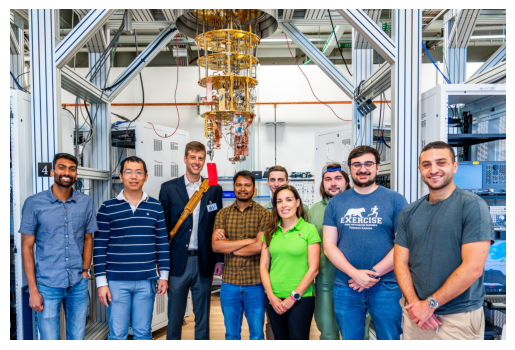

In [5]:
image_path = "quantum.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")

In [22]:
image_path = "quantum.jpg"
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()
image_data = base64.b64encode(image_data).decode("utf-8")

## Image Captioning

In [23]:
image_path = "quantum.jpg"
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()
    
image_data = base64.b64encode(image_data).decode("utf-8")

prompt="""explain this image"""
message = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

'The image shows a group of people standing in front of a large, complex piece of machinery. The machinery appears to be a quantum computer, with many wires and components visible. The people are likely scientists or engineers who work with the quantum computer. They are all smiling and looking at the camera, suggesting that they are proud of their work. The image conveys a sense of excitement and innovation, as well as the importance of teamwork in scientific research.'

## Extraction

In [28]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import json

class Retrieval(BaseModel):
    Description: str = Field(description="Describe the image")
    Machine: str = Field(description="Explain what is the machine about")
    Color: str = Field(description="What are the color used in the image")
    People: str = Field(description="Count how many male and female are standing their")

parser = PydanticOutputParser(pydantic_object=Retrieval)

prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the requested details as per the given details.\n'{struct_format}'\n"),
    ("human", [
        {
            "type": "image_url",
            "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
        },
    ]),
])

chain = prompt | llm | parser

image_path = "quantum.jpg"
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()
    
image_data = base64.b64encode(image_data).decode("utf-8")


response = chain.invoke({
    "struct_format": parser.get_format_instructions(),
    "image_data": image_data
})

data = json.loads(response.model_dump_json())

for k,v in data.items():
    print(f"{k}: {v}")

## OCRing

In [42]:
image_path = "qubits.png"
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()
    
image_data = base64.b64encode(image_data).decode("utf-8")

prompt="""Extract all the text from the image"""
message = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

Qubit vs bit

Qubits are represented by a superposition of multiple possible states

A qubit uses the quantum mechanical phenomena of superposition to achieve a linear combination of two states. A classical binary bit can only represent a single binary value, such as 0 or 1, meaning that it can only be in one of two possible states. A qubit, however, can represent a 0, a 1, or any proportion of 0 and 1 in superposition of both states, with a certain probability of being a 0 and a certain probability of being a 1.

Superposition gives quantum computers superior computing power

Superposition allows quantum algorithms to process information in a fraction of the time it would take even the fastest classical systems to solve certain problems.

* The amount of information a qubit system can represent grows exponentially. Information that 500 qubits can easily represent would not be possible with even more than 2^500 classical bits.
* It would take a classical computer millions of years to f

## Object segementation

In [52]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List

import json

class Segmentation(BaseModel):
    Object: List[str] = Field(description="Identify the object and give a name")
    Bounding_box: List[List[int]] = Field(description="Extract the bounding boxes")


parser = PydanticOutputParser(pydantic_object=Segmentation)

prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract all the image objects and their bounding boxes. You must always return valid JSON.\n'{struct_format}'\n"),
    ("human", [
        {
            "type": "image_url",
            "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
        },
    ]),
])

chain = prompt | llm | parser

image_path = "quantum.jpg"
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()
    
image_data = base64.b64encode(image_data).decode("utf-8")


response = chain.invoke({
    "struct_format": parser.get_format_instructions(),
    "image_data": image_data
})



In [53]:
data = json.loads(response.model_dump_json())

for k,v in data.items():
    print(f"{k}: {v}")

Object: ['Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
Bounding_box: [[433, 15, 998, 168], [446, 164, 998, 316], [396, 302, 998, 416], [496, 405, 998, 521], [526, 509, 998, 631], [483, 615, 998, 701], [404, 662, 998, 814], [402, 788, 998, 966], [0, 334, 500, 526]]


In [64]:
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im,labels, bounding_boxes):
    """
   Code sourced from https://github.com/google-gemini/cookbook/blob/main/gemini-2/spatial_understanding.ipynb
  https://github.com/google-gemini/cookbook/blob/main/gemini-2/spatial_understanding_3d.ipynb
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors



    font = ImageFont.truetype("arial.ttf", size=14)

    for i,(lbl, bounding_box) in enumerate(zip(labels,bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box[0]/1000 * height)
      abs_x1 = int(bounding_box[1]/1000 * width)
      abs_y2 = int(bounding_box[2]/1000 * height)
      abs_x2 = int(bounding_box[3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )
      draw.text((abs_x1 + 8, abs_y1 + 6), lbl, fill=color,font=font) # , font=font

    # Display the image
    img.show()

In [65]:
plot_bounding_boxes(im=img,labels=data['Object'], bounding_boxes=data['Bounding_box'])

(3000, 2000)
